## Introdução

Este projeto tem o objetivo de criar um modelo para a identificação de transações bancárias fraudulentas.

Dentre as principais etapas do processo, estão:

1. **Análise exploratória dos dados**
2. **Criação de novas features**
3. **Criação do modelo preditivo**
4. **Verificação da performance dos modelos**


### Biliotecas e Configurações

In [39]:

import pandas as pd  
import numpy as np    

import matplotlib.pyplot as plt  
import matplotlib as mpl         
import seaborn as sns            

from sklearn.preprocessing import OneHotEncoder   
from sklearn.preprocessing import StandardScaler   
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split    
from sklearn.model_selection import cross_val_score, KFold  

from sklearn.linear_model import LogisticRegression    
from sklearn.ensemble import RandomForestClassifier    
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report

from skopt import BayesSearchCV

from collections import Counter

mpl.style.use('ggplot') 

mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['figure.dpi']          = 150
mpl.rcParams['axes.grid']           = True
mpl.rcParams['font.size']           = 12

# Palette Setting
color_palette = ['#003851ff', '#3F48F2', '#3F81F2', '#3FF2F2', '#9F7FF5', '#90B4F2']

# Setting as the palette
sns.set_palette(sns.color_palette(color_palette))
# Display
sns.color_palette(color_palette)

[(0.0, 0.2196078431372549, 0.3176470588235294),
 (0.24705882352941178, 0.2823529411764706, 0.9490196078431372),
 (0.24705882352941178, 0.5058823529411764, 0.9490196078431372),
 (0.24705882352941178, 0.9490196078431372, 0.9490196078431372),
 (0.6235294117647059, 0.4980392156862745, 0.9607843137254902),
 (0.5647058823529412, 0.7058823529411765, 0.9490196078431372)]

### Problema

Transações bancárias fraudulentas representam um grande problema para instituições em todo o mundo, dado o número crescente de novos golpes sendo criados. Tendo isso em mente, a utilização de métodos mais sofisticados para a detecção de atividades fraudulentas se tornou uma tarefa tão crucial quanto complexa.

Métodos como a análise de dados e a criação de modelos utilizando aprendizado de máquina têm sido de grande contribuição para a solução desses problemas, permitindo reconhecer e relacionar features importantes e relevantes para a tomada de decisões.

### Objetivo

- Construir um modelo preditivo capaz de identificar com exatidão as transações fraudulentas.
- Identificar features relevantes para a detecção de transações suspeitas, possibilitando ações preventivas por parte do banco.

### Entendendo os dados

- O banco de dados foi retirado do kaggle: https://www.kaggle.com/datasets/ealaxi/paysim1

- Os dados contem colunas com informações como: quantia de transação, tipo de pagamento, tempo transcorrido, etc.

- Os dados são rotulados como 1 para fraudes e 0 para nao fraudes.

In [2]:
df = pd.read_csv('fraud_detection_dataset.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### Dicionario dos dados.

- **`step`**: representa uma unidade de tempo onde 1 passo equivale a 1 hora.
- **`type`**: tipo de transação online.
- **`amount`**: o valor da transação.
- **`nameOrig`**: cliente que inicia a transação.
- **`oldbalanceOrg`**: saldo antes da transação.
- **`newbalanceOrig`**: saldo após a transação.
- **`nameDest`**: destinatário da transação.
- **`oldbalanceDest`**: saldo inicial do destinatário antes da transação.
- **`newbalanceDest`**: o novo saldo do destinatário após a transação.
- **`isFraud`**: transação fraudulenta.

- **`isFlaggedFraud`**: SinalizadaComoFraude automaticamente marcadas pelo banco como fraude por tentarem transferir mais de 200.000 em uma única transação.

- **`M`** e **`C`** Merchants(Comerciantes) e Customers(Cliente)

**`NOTA`**: As transações detectadas como fraude são canceladas, portanto para detecção de fraude estas colunas (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) não devem ser utilizadas.

## Análise exploratória de dados

Infomações gerais como: Quantidade de linhas, valores nulos e tipo de variaveis.

In [3]:
df.info(null_counts=True)

C:\Users\walla\AppData\Local\Temp\ipykernel_39084\1982639406.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

Os valores discrepantes entre as variáveis 1 e 0 revelam um grande desbalanceamento nos dados, que deve ser levado em consideração ao avaliar as métricas, como, por exemplo, a acurácia. Isso porque, em um modelo que sempre classifica uma transação como não fraudulenta, ele acertaria 99,8% das vezes. No entanto, o rótulo mais importante para o nosso modelo é o reconhecimento de transações fraudulentas.

Podemos então analisar mais a fundo as variáveis categóricas. Para uma primeira análise, podemos observar a proporção de recorrência das mesmas. Primeiro, analisarei a coluna **`type`**, que se refere ao tipo de transação realizada.


In [7]:
print(f'A quantidade de valores únicos encontrados foi:{df["type"].nunique()}')
print(df['type'].value_counts(normalize=True))

A quantidade de valores únicos encontrados foi:5
CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: type, dtype: float64


Podemos observar uma grande dominancia CASH_OUT, PAYMENT e CASH_IN. Observaremos a ocorrecia de fraudes para com as mesmas.

In [8]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Text(0, 0.5, 'Número de Fraudes')

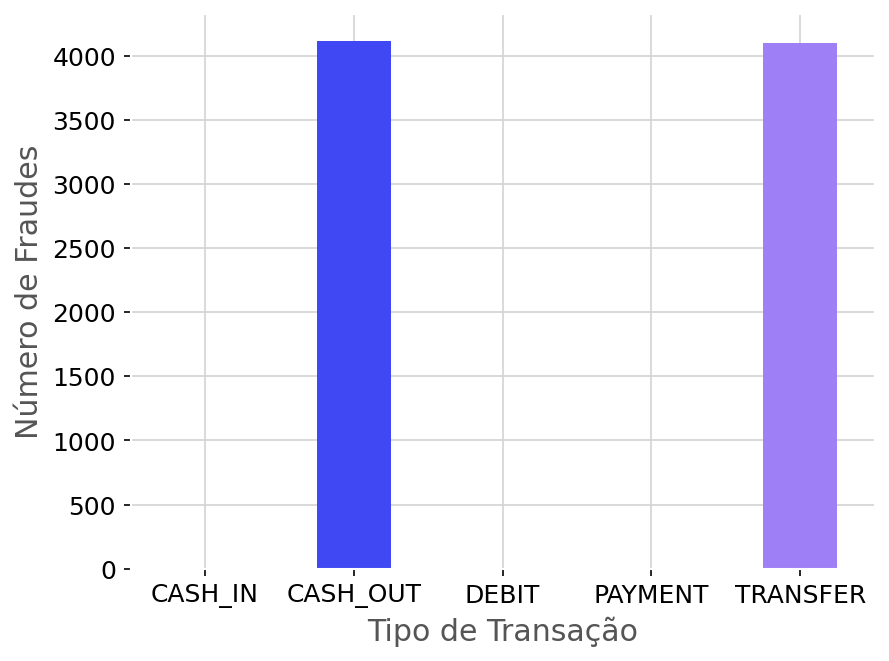

In [9]:
df.groupby('type').sum(numeric_only=True)['isFraud'].plot(kind='bar', color=color_palette,rot=0)
plt.xlabel('Tipo de Transação')
plt.ylabel('Número de Fraudes')



O gráfico mostra que apenas **`TRANSFER`** e **`CASH_OUT`** são utilizados em fraudes. Isso pode ocorrer porque esses métodos permitem a movimentação direta do dinheiro para uma conta controlada pelo fraudador, seguida de sua retirada em dinheiro. Diante disso, podemos investigar se esse é realmente o modus operandi do golpe, analisando mais a fundo como essas operações estão relacionadas.

Outra pergunta que surge é se o mesmo nome é recorrente em nossos dados com o rótulo de fraude. Isso poderia revelar que uma mesma pessoa aplica vários golpes em diferentes vítimas para benefício próprio.

In [10]:
print('Os 5 primeiros nomes de origem mais repetidopos: ')
print(df['nameOrig'].value_counts()[:5])
print('\nOs 5 primeiros nomes de destino mais repetidopos: ')
print(df['nameDest'].value_counts()[:5])

Os 5 primeiros nomes de origem mais repetidopos: 
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
Name: nameOrig, dtype: int64

Os 5 primeiros nomes de destino mais repetidopos: 
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
Name: nameDest, dtype: int64


Há uma discrepância entre a quantidade de nomes repetidos nos dois conjuntos. Faz sentido haver mais nomes repetidos entre os destinatários, já que, ao realizar uma transferência fraudulenta, é necessário obter esse dinheiro a partir de uma conta também. Com isso em mente, podemos analisar a quantidade de transações fraudulentas relacionadas a esses nomes.

In [11]:
print('Os 5 primeiros nomes de origem mais repetidopos, rotulados como fraudes: ')
print(df[df['isFraud']==1]['nameOrig'].value_counts()[:5])
print('\nOs 5 primeiros nomes de destino mais repetidopos rotulados como fraudes:')
print(df[df['isFraud']==1]['nameDest'].value_counts()[:5])

Os 5 primeiros nomes de origem mais repetidopos, rotulados como fraudes: 
C1305486145    1
C755286039     1
C973279667     1
C258213312     1
C1640703547    1
Name: nameOrig, dtype: int64

Os 5 primeiros nomes de destino mais repetidopos rotulados como fraudes:
C1193568854    2
C104038589     2
C200064275     2
C1497532505    2
C1601170327    2
Name: nameDest, dtype: int64


Obtivemos poucos valores repetidos, revelando que não é uma informação tão útil. Para um último teste, podemos observar que, no código escrito, há letras e números aleatórios. Podemos nos perguntar qual é a relação entre transações de clientes e comerciantes em relação às fraudes.

In [12]:
print(Counter(''.join(df['nameOrig'].tolist())))
print(Counter(''.join(df['nameDest'].tolist())))



Counter({'1': 8803448, 'C': 6362620, '2': 6136135, '3': 5699596, '4': 5693146, '7': 5669437, '5': 5668010, '6': 5667725, '0': 5667074, '9': 5665212, '8': 5662637})
Counter({'1': 8799996, '2': 6133780, '3': 5704404, '4': 5691070, '8': 5675627, '9': 5668861, '7': 5665128, '0': 5664751, '6': 5662897, '5': 5662271, 'C': 4211125, 'M': 2151495})


Apenas as letras C e M aparecem no conjunto de dados nameDest. Podemos entao criar um rotulo para substituir essas duas colunas tentando relacionar essas letras entre colunas.

In [13]:
df['type2'] = np.nan
df.loc[df['nameOrig'].str.contains('C') & df['nameDest'].str.contains('C'), 'type2'] = 'CC'
df.loc[df['nameOrig'].str.contains('C') & df['nameDest'].str.contains('M'), 'type2'] = 'CM'
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type2
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,CM
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,CM
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,CC
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,CC
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,CM


In [14]:
df[df['isFraud'] == 1].groupby('type2').sum(numeric_only=True)['isFraud']

type2
CC    8213
Name: isFraud, dtype: int64

Text(0, 0.5, 'Número de Fraudes')

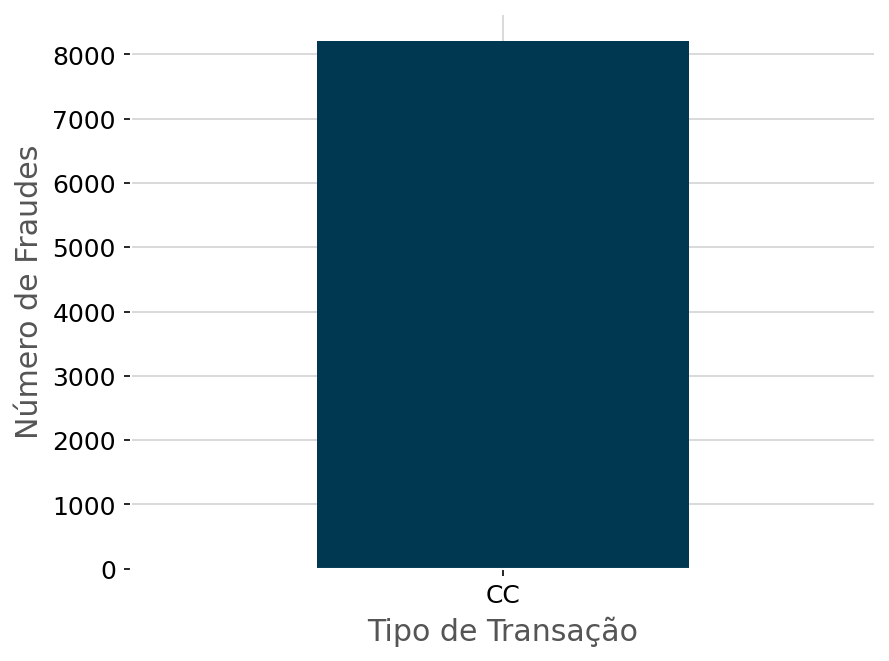

In [15]:
df[df['isFraud'] == 1].groupby('type2').sum(numeric_only=True)['isFraud'].plot(kind='bar', color=color_palette,rot=0)
plt.xlabel('Tipo de Transação')
plt.ylabel('Número de Fraudes')

O gráfico mostra que apenas as relações entre Cliente e Cliente apresentam transações fraudulentas. Combinando essas informações, podemos rotular essas operações com seus respectivos tipos, revelando que apenas transações entre clientes estão associadas a fraudes. Ou seja, operações envolvendo comerciantes não fazem parte do modus operandi do golpe.

In [16]:
df[df['isFraud'] == 1].groupby(['type','type2']).size().reset_index(name='counts')

,type,type2,counts
0,CASH_OUT,CC,4116
1,TRANSFER,CC,4097


Podemos entao substitur as duas colunas nameOrig e nameDest pela nova colunas type 2.

In [17]:
df.drop(['nameOrig', 'nameDest'], axis = 1, inplace= True)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type2
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,CM
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,CM
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,CC
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,CC
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,CM


Agora, analisando a coluna step, podemos nos perguntar como essas transações se comportam ao longo do tempo. Primeiramente, é necessário transformar a coluna step para facilitar sua interpretação.

In [18]:
from datetime import datetime as dt
from datetime import timedelta as td

data_inicio = dt(2024, 1, 1, 0)
step_final = df['step'].max()
step_inicial = df['step'].min()
datas = [data_inicio]

for i in range(step_inicial, step_final):
    data_inicio += td(seconds=3600)
    datas.append(data_inicio)


df_datas = pd.DataFrame({'dates': datas})
df_datas['hour'] = df_datas['dates'].dt.hour
df_datas['step'] = df_datas.index + 1
df_datas.drop(['dates'], axis =1, inplace= True)
df_datas.head()

,hour,step
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5


In [19]:
df = pd.merge(df, df_datas, on=['step'], how = 'left')

In [20]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type2,hour
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,CM,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,CM,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,CC,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,CC,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,CM,0


0


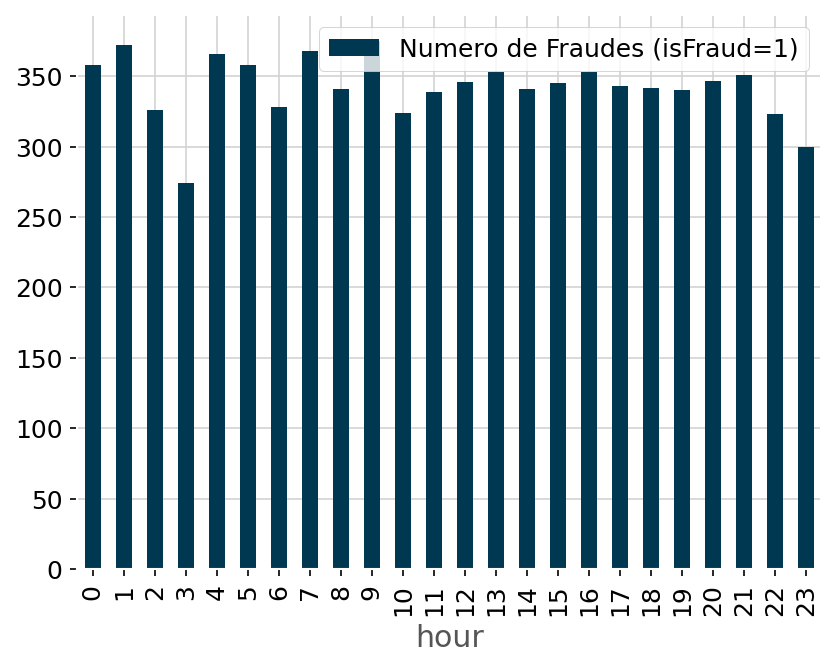

In [21]:

df_isFraud_fraud = df.groupby(['hour', 'isFraud']).size().reset_index(name='count').astype(int)
df_isFraud_fraud[df_isFraud_fraud['isFraud']==1].plot(kind = 'bar', x= 'hour', y = 'count')
plt.legend(['Numero de Fraudes (isFraud=1)'])
print(df['hour'].isna().sum())

O número de transações fraudulentas aparenta ser constante, mantendo a mesma ordem de grandeza em todos os horários do dia. No entanto, é necessário conhecer a quantidade total de transações realizadas para uma análise mais completa.

<AxesSubplot: xlabel='hour'>

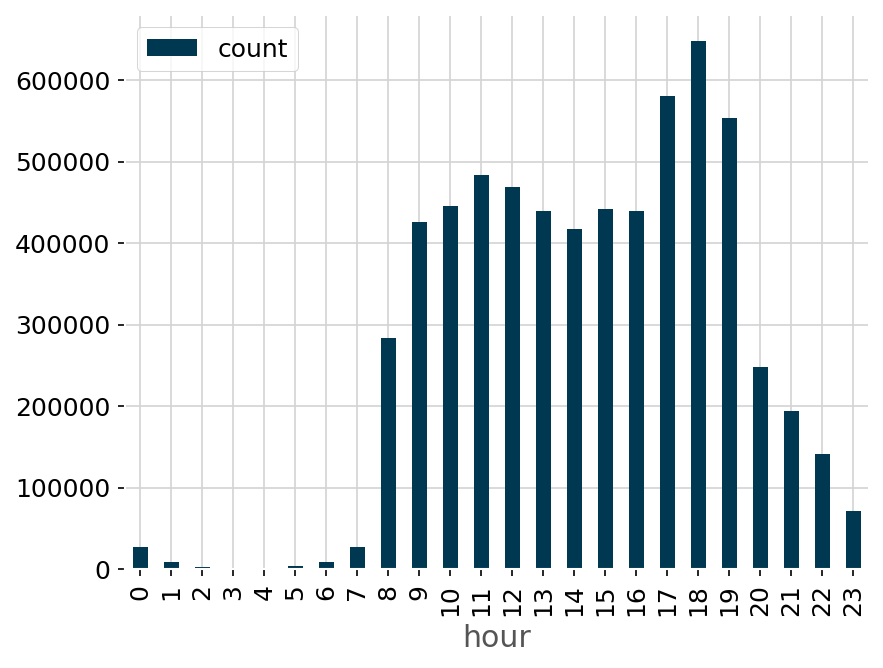

In [22]:

df.groupby(['hour']).size().reset_index(name='count').astype(int).plot(kind = 'bar', x= 'hour', y = 'count')



Podemos ver um número bem reduzido de transações no período de 0 a 7 horas. Para uma análise mais correta, é necessário analisarmos a proporção de transações fraudulentas em cada período, visto que o número de transações fraudulentas em comparação a um baixo número de transações totais, é bem mais relevante do que o mesmo valor em um número elevado de transações feitas no dia

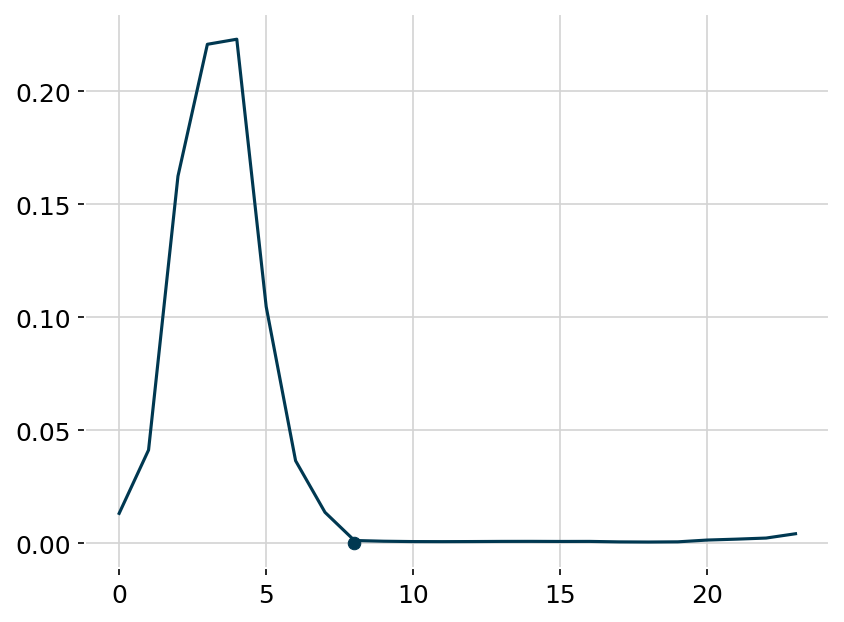

In [23]:
pro = np.array(df_isFraud_fraud[df_isFraud_fraud['isFraud'] == 1]['count']) / np.array(df_isFraud_fraud.groupby(['hour']).sum()['count'])
plt.plot(pro)
plt.scatter(x = 8, y = 0)

O gráfico revela que, mesmo o número de operações fraudulentas sendo relativamente constante, em proporção, no período de 0 a 7 horas existe uma probabilidade bem maior de serem operações fraudulentas, revelando que o período da ocorrência da operação é bastante relevante para a análise.

Podemos então criar uma classe que representa qual o periodo a trasação foi realizada.

In [24]:
df_horas_classe = pd.DataFrame({'hour':       [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
                                'hour_class': [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]}, dtype=int)



df = pd.merge(df, df_horas_classe, on=['hour'], how = 'left')

In [25]:
df.head()


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type2,hour,hour_class
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,CM,0,1
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,CM,0,1
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,CC,0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,CC,0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,CM,0,1


Agora podemos remover as colunas que não são mais relevantes. Também há uma nota no site de obtenção do conjunto de dados que alerta para não utilizar as colunas `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest` e `newbalanceDest` na criação de modelos de predição.

In [26]:
df.drop(['step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','hour','isFlaggedFraud'],axis = 1, inplace= True)
df.head()


,type,amount,isFraud,type2,hour_class
0,PAYMENT,9839.64,0,CM,1
1,PAYMENT,1864.28,0,CM,1
2,TRANSFER,181.00,1,CC,1
3,CASH_OUT,181.00,1,CC,1
4,PAYMENT,11668.14,0,CM,1


## Preprocessamento

- Antes de prosseguir com os próximos passos, realizarei a separação entre o conjunto de treino e teste.

- Todas as etapas serão aplicadas apenas ao conjunto de treino, evitando vazamento de dados e garantindo uma boa representação e avaliação correta do modelo para com novos dados, devido ao isolamento prévio.

- Defini a função `stratify=True` para garantir uma divisão realista, mantendo a proporção original dos dados.

- Também realizarei o balanceamento dos dados, reduzindo os dados majoritários (não fraudes) para evitar overfitting. Existem outras formas de lidar com o desbalanceamento, como aumentar os dados da classe minoritária, seja obtendo novos dados ou criando-os a partir dos dados reais existentes no conjunto de dados, ou ponderando os pesos das classes a serem classificadas de acordo com sua proporção.

- Decidi realizar o balanceamento por meio da redução dos dados majoritários, pois a quantidade de dados no conjunto aumentaria significativamente o custo computacional dos testes e da criação do modelo.


In [27]:
df_features = df.drop('isFraud', axis= 1)
df_target = df['isFraud']

In [28]:
smote = RandomUnderSampler()
df_features, df_target = smote.fit_resample(
    df_features,
    df_target,
    )

y_train_resampled_series = pd.Series(df_target)
y_train_resampled_series.value_counts()

0    8213
1    8213
Name: isFraud, dtype: int64

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    df_features, df_target, test_size=0.2, shuffle=True, stratify = df_target)


Também é necessário normalizar os dados numéricos, visto que alguns algoritmos utilizam cálculos baseados em distância ou métodos de otimização, como o gradient descent, que são sensíveis à escala dos números. Já para as colunas categóricas `type` e `type2`, utilizaremos o OneHotEncoder, pois não apresentam graus de importância entre suas variáveis.

In [30]:
label_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_train_encoded = label_encoder.fit_transform(X_train[['type', 'type2']])
X_test_encoded = label_encoder.transform(X_test[['type','type2']])

X_train_encoded = pd.DataFrame(X_train_encoded, columns=label_encoder.get_feature_names_out())
X_test_encoded = pd.DataFrame(X_test_encoded, columns=label_encoder.get_feature_names_out())



In [31]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()
X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

X_train.head()

,index,type,amount,type2,hour_class,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1181348,TRANSFER,1845830.36,CC,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1778801,CASH_OUT,228473.10,CC,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,4107396,CASH_OUT,15103.06,CC,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1511342,TRANSFER,17569.42,CC,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,2530946,CASH_OUT,248422.22,CC,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [32]:
X_train.drop(['type','type2'], axis =1 ,inplace=True)
X_test.drop(['type','type2'], axis = 1,inplace=True)
X_train.head()


,index,amount,hour_class,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1181348,1845830.36,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1778801,228473.10,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,4107396,15103.06,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1511342,17569.42,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,2530946,248422.22,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [33]:
scaler = StandardScaler()

X_train['amount_scaled'] = scaler.fit_transform(X_train[['amount']])
X_test['amount_scaled'] = scaler.fit_transform(X_test[['amount']])
X_test.head()


,index,amount,hour_class,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM,amount_scaled
0,6020255,1464614.79,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.418089
1,3823689,203038.29,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.331688
2,6263052,279812.98,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.286059
3,5987484,1050135.78,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.171757
4,985194,213983.59,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.325183


In [34]:
X_train.drop(['amount','index'], axis =1 ,inplace=True)
X_test.drop(['amount','index'], axis = 1,inplace=True)
X_train[X_train.columns[:-1]] = X_train[X_train.columns[:-1]].astype(int)
X_train.head()

,hour_class,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM,amount_scaled
0,0,0,0,0,0,1,1,0,0.533302
1,0,0,1,0,0,0,1,0,-0.322798
2,0,0,1,0,0,0,1,0,-0.435739
3,1,0,0,0,0,1,1,0,-0.434434
4,0,0,1,0,0,0,1,0,-0.312239


## Criação do Modelo

Com todas as etapas de preprocessamento concluídas, podemos finalmente avaliar o desempenho dos modelos em relação ao nosso conjunto de dados. Testei três modelos de classificação em busca daquele que apresentasse o melhor desempenho sem, a princípio, a necessidade de otimizações com hiperparâmetros.

Para a validação dos modelos, utilizei o cross_val_score, que aplica o K-fold cross-validation. Esse método divide os dados em K subgrupos, e em cada iteração, um subgrupo é utilizado como conjunto de teste, enquanto os outros são usados para treino. Isso é repetido K vezes, rotacionando os grupos, ou seja, todos os subgrupos serão utilizados uma vez como grupo de teste. Ao final, é calculada a média das métricas de validação, garantindo uma avaliação mais realista.

In [40]:
tree_models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "SVC": SVC()
}


def classification_kfold_cv(models, X_train, y_train, n_folds):
    results = []
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for name, model in models.items():
        cv_scores_ac = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
        cv_scores_re = cross_val_score(model, X_train, y_train, cv=kf, scoring='recall')
        cv_scores_pre = cross_val_score(model, X_train, y_train, cv=kf, scoring='precision')
        cv_scores_f1 = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1')
        results.append({
            "Model": name,
            "Mean Accuracy": cv_scores_ac.mean(),
            "Mean recall": cv_scores_re.mean(),
            'Mean precision':cv_scores_pre.mean(),
            'Mean f1':cv_scores_f1.mean()
        })
    
    return pd.DataFrame(results)

eval_df = classification_kfold_cv(models=tree_models, 
                                  X_train=X_train, 
                                  y_train=y_train, 
                                  n_folds=5)

print(eval_df)

                 Model  Mean Accuracy  Mean recall  Mean precision   Mean f1
0  Logistic Regression       0.854110     0.804572        0.892969  0.846399
1        Random Forest       0.806393     0.804141        0.808098  0.805970
2              XGBoost       0.855784     0.840969        0.866682  0.853543
3                  SVC       0.855479     0.808227        0.892511  0.848240


Com esses resultados, decidi seguir com o modelo XGBoost. Para buscar os hiperparâmetros ideais, utilizei o `BayesSearchCV`. O `BayesSearchCV` é uma ferramenta de otimização de hiperparâmetros baseada em busca bayesiana, que utiliza métodos probabilísticos para selecionar os próximos conjuntos de hiperparâmetros com base nos resultados anteriores. Existem outros métodos de otimização, como o `GridSearchCV`, que testa todas as combinações em uma limite predefinida, ou até mesmo o `RandomizedSearchCV`, que explora combinações aleatórias.


In [64]:
param_grid = {
    'n_estimators': [100, 200,300,400],
    'max_depth': (3, 25),
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'colsample_bytree': (0.1, 1.0),
    'subsample': (0.1, 1.0),
    'gamma': (0, 15),
    'min_child_weight': (1, 20)
}

rfc = XGBClassifier()
opt = BayesSearchCV(rfc, param_grid, n_iter=32, cv=3, n_jobs=-1)

In [63]:

opt.fit(X_train, y_train)
y_pred = opt.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1643
           1       0.89      0.85      0.87      1643

    accuracy                           0.87      3286
   macro avg       0.87      0.87      0.87      3286
weighted avg       0.87      0.87      0.87      3286



Por fim, podemos analisar as features mais relevantes para o modelo:

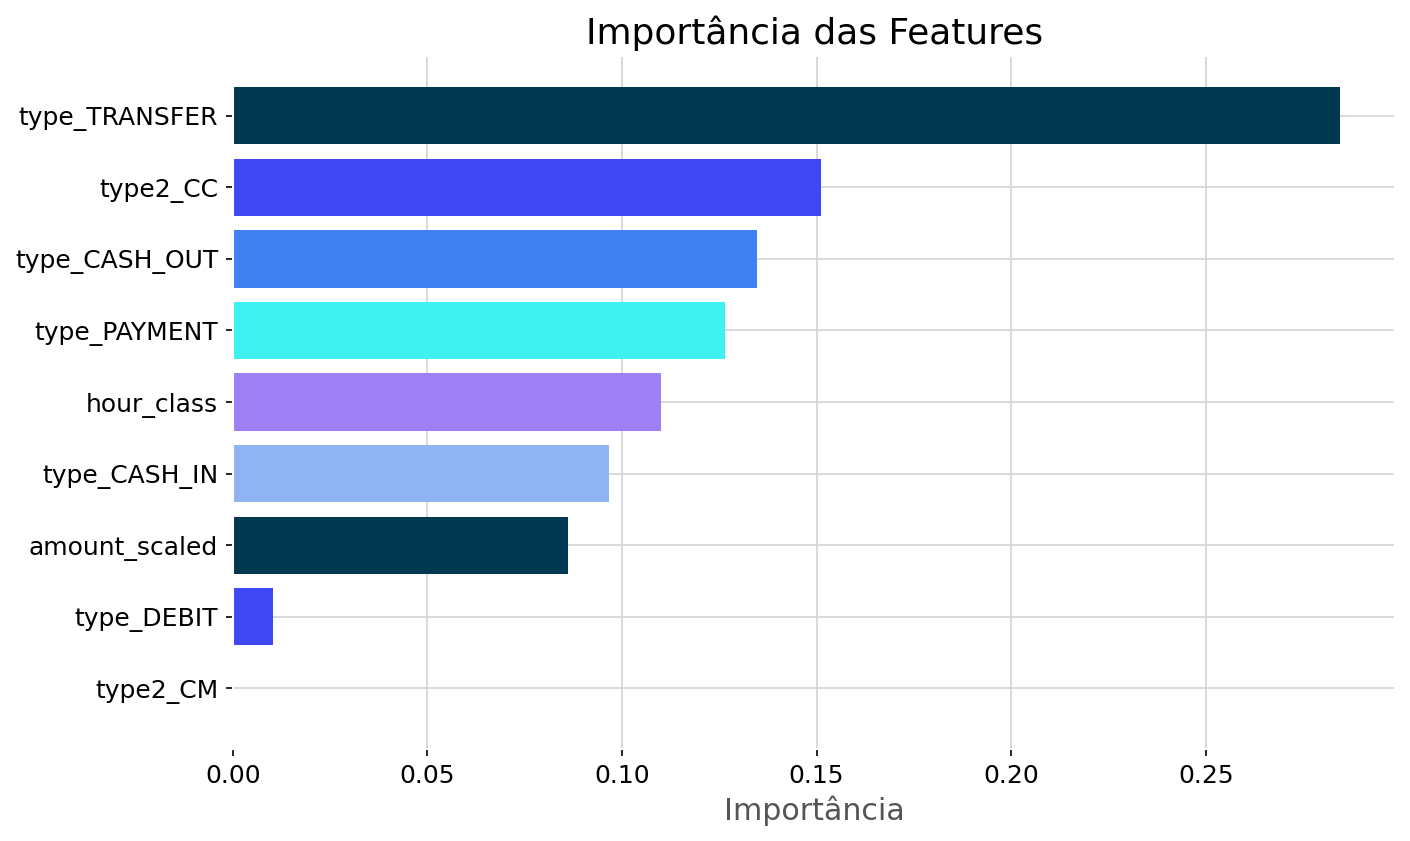

In [66]:

importances = opt.best_estimator_.feature_importances_

features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color=color_palette)
plt.xlabel('Importância')
plt.title('Importância das Features')
plt.gca().invert_yaxis()  
plt.show()

## Conclusão

A análise deste projeto revelou:

- A concentração de fraudes está nas operações de **CASH_OUT** e **TRANSFER**.
  
- Não há uma recorrência significativa de um mesmo cliente retirando dinheiro a partir de uma operação fraudulenta, revelando que o dinheiro é retirado em contas diferentes.

- Não há transações fraudulentas referentes a Cliente e Comércio, indicando que os Modus Operandi dessa operação ocorrem apenas de Cliente para Cliente.

- No período das 0 às 7 horas, há uma grande concentração, em proporção, de operações fraudulentas em comparação com o período das 8 às 23 horas.

- As três features mais relevantes foram **TRANSFER**, **TYPE2** e **CASH_OUT**. Com isso, é possível observá-las mais de perto para aumentar a segurança das operações.

- O modelo se mostrou confiável na detecção de fraudes. O equilíbrio entre precisão e recall, aliado a uma alta acurácia, sugere que o modelo pode ser um aliado eficaz para sua proposta.
